# Funções Auxiliares

In [ ]:
def get_feature_names(column_transformer):
    """Função retirada de https://johaupt.github.io/blog/columnTransformer_feature_names.html"""
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline: #sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline: #sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [ ]:
def cross_validation(X,y, n_folds, model):

    score_metrics = ["average_precision","f1", "recall", "precision"]
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

    cross_val = cross_validate(model,X,y,scoring = score_metrics, cv = cv, return_train_score = True)
    y_hat = cross_val_predict(model, X, y, cv = cv)


    return cross_val

# Importando Pacotes e Carregando os Dados

In [ ]:
import pickle
import warnings
warnings.filterwarnings("ignore")
#core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

from BorutaShap import BorutaShap

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

#pre-processing
from sklearn.compose import make_column_transformer
from category_encoders import OneHotEncoder, HashingEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

#model selection
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import average_precision_score, f1_score, recall_score, precision_score

import optuna
from optuna.samplers import TPESampler

from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from yellowbrick.classifier import PrecisionRecallCurve, ConfusionMatrix, ClassificationReport
from yellowbrick.classifier import ROCAUC

import shap
import copy as cpy
# Options
pd.options.display.max_columns = 50

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

custom_params = {"axes.spines.left": False, "axes.spines.bottom": False, "axes.spines.top":False, "axes.spines.right":False}
sns.set_theme(rc = custom_params, style="white", palette="muted", font_scale=1) #Muted #pastel

In [ ]:
train_raw = pd.read_csv("./data/train.csv").drop("Unnamed: 0", axis = 1)
test_raw = pd.read_csv("./data/test.csv").drop("Unnamed: 0", axis = 1)

In [ ]:
train = train_raw.copy()
test = test_raw.copy()

In [ ]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


# Pre-processamento

O pré-processamento consistiu no encode das features categoricas e padronização das númericas. As categórias binárias foram convertidas manualmente. As restantes foram processadas via pipeline. 

In [ ]:
#encode manual das binárias
binary_dic = {"no": 0, "yes":1}

train["international_plan"] = train["international_plan"].map(binary_dic)
test["international_plan"] = test["international_plan"].map(binary_dic)

train["voice_mail_plan"] = train["voice_mail_plan"].map(binary_dic)
test["voice_mail_plan"] = test["voice_mail_plan"].map(binary_dic)

train["churn"] = train["churn"].map(binary_dic)
test["churn"] = test["churn"].map(binary_dic)

In [ ]:
#separando features preditoras da target
X_train = train.drop("churn", axis = 1)
y_train = train["churn"]

X_test = test.drop("churn", axis = 1)
y_test = test["churn"]

In [ ]:
X_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,KS,128,area_code_415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [ ]:
#definindo pipeline de pré-processamento
to_hashing = ["state"]
to_OHE = ["area_code"]
num_cols = X_train.select_dtypes(include = np.number).columns.to_list()

ct = make_column_transformer(
    
    (OneHotEncoder(), to_OHE),
    (HashingEncoder(), to_hashing),
    (StandardScaler(), num_cols)
    
)

# Adversarial Validation

Antes de iniciar qualquer procedimento, irei verificar a presença de shift. Em outras palavras, se as distribuições dos dados de treino e teste são diferentes. Em caso positivo, estimativas obtidas com a validaçao cruzada nos dados de treino não serão representativas para os dados de teste, sendo então necessário identiicar a causa do shift e trata-la.

A ideia é criar um rótulo dferenciando os dados de treino e teste e tentar, juntá-los em um único dataframe e tentar prêve-los com um classificador simples. Caso o modelo tenha uma alta perfomance (consiga diferenciar bem entre as classes) há a presença de shift, indicando que há fatores que fazem com que a distribuição desses dois conjuntos sejam diferentes. Por outro caso, caso o modelo apresente baixa performance (tenha dificuldade em separar as classes), podemos concluir que a distribuição em treino e teste são similares e a validação cruzada fornecerá uma boa estimativa.


In [ ]:
#criando dataframes com rótulos de 0 para treino e 1 para teste
X_train_AV = X_train.copy()
X_train_AV["target"] = 0

X_test_AV = X_train.copy()
X_test_AV["target"] = 1

In [ ]:
#unindo os dois dfs e embaralhando
df_master = pd.concat([X_train_AV,X_test_AV], axis = 0)
df_master = df_master.sample(frac=1).reset_index(drop=True) #shuffle
df_master.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute,plan,target
0,LA,106,area_code_408,0,0,0,220.7,120,37.52,270.2,95,22.97,121.6,113,5.47,8.7,5,2.35,1,68.31,621.2,334,0.109965,Nenhum,1
1,KS,107,area_code_415,0,0,0,260.5,108,44.29,102.4,110,8.70,129.7,148,5.84,9.8,5,2.65,1,61.48,502.4,372,0.122373,Nenhum,0
2,MT,160,area_code_415,0,0,0,97.5,113,16.58,268.1,69,22.79,255.3,62,11.49,13.2,4,3.56,3,54.42,634.1,251,0.085822,Nenhum,1
3,CO,76,area_code_408,0,1,26,214.6,110,36.48,205.2,87,17.44,134.6,140,6.06,8.1,2,2.19,1,62.17,562.5,340,0.110524,Apenas Correio de Voz,0
4,TX,41,area_code_408,0,1,22,213.8,102,36.35,141.8,86,12.05,142.2,123,6.40,7.2,3,1.94,0,56.74,505.0,314,0.112356,Apenas Correio de Voz,0


In [ ]:
#separano em treino e teste
adversarial_train = df_master[:len(train)]
adversarial_test = df_master[len(train):]

#separando features preditoras do target
X_train_AV = adversarial_train.drop("target", axis = 1)
y_train_AV = adversarial_train["target"]

X_test_AV = adversarial_test.drop("target", axis = 1)
y_test_AV = adversarial_test["target"]

#aplicando encode
X_train_AV_enc = ct.fit_transform(X_train_AV)
X_test_AV_enc = ct.transform(X_test_AV)

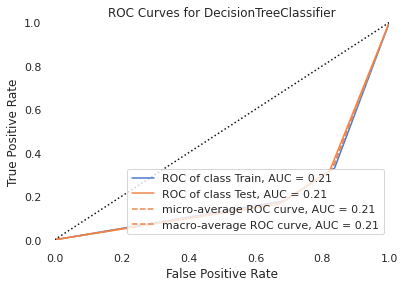

In [ ]:
#Treinando uma Decision Tree e aaaliando com a cuva ROC
model = DecisionTreeClassifier()
visualizer = ROCAUC(model, classes = ["Train","Test"])

visualizer.fit(X_train_AV_enc, y_train_AV)
visualizer.score(X_test_AV_enc, y_test_AV)
visualizer.show();

Como o valor de AUC foi muito baixo (0.21) para as duas classes, podemos concluir que o modelo teve dificuldades para diferenciar entre treino e teste, indicando que a distribuição desses é similar.

# Model Selection

6 diferentes modelos foram avaliados, inicialmente nos dados originas e depois nos dados pós feature engineering para avaliar o efeito da adição de novas features.

- Logistic Regression (logit): Separador linear de alta interpretabilidade
- Decision Tree (DT): Classificador baseado em regras, também é facilmente interpretado. Note que o crescimento da árvore foi limitado para evitar sobreajuste.
- Random Forest (RF): Ensemble bagging de árvores de decisão. Cada uma das 300 árores de decisão também tiveram o seu crescimento limitado.
- k-Nearest Neighbors (KNN): Classificador baseado na distância matemática entre pontos de dados. 
- Support Vector Machine (SVM): Originalmente separa as lasses linearmente mas com o kernel polinomial ativo torna a fronteira de decisão não linear.
- Light Gradient Boosting Machine (LGBM): Ensemble boosting de árvores de decisão   

As métrcas utilizadas para comparação dos modelos foram a precision-recall curve representada no sklearn pelo average precision score (AP score), o f1 e também o recall e a precisão individualmente, com maior enfoque no recall. 



In [ ]:
models = {}
models["Logit"] = LogisticRegression(random_state = 42)
models["Decision Tree"] = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)
models["Random Forest"] = RandomForestClassifier(n_estimators=300,min_samples_leaf=20, max_depth=5, random_state=42)
models["KNN"] = KNeighborsClassifier()
models["SVM"] = SVC(kernel="poly", degree=3, probability=True, random_state=42, C=0.25)
models["LGBM"] = LGBMClassifier(random_state = 42)

## Sem Feature Enginering

Cada modelo foi avaliado em uma validação cruzada (4 folds). É necessário passar como argumento para a  função cross validation um pipeline contendo o pré-processamento e o estimador como etapas. Isso garante que para cada separação dos folds em treino e validação haja um "fit" do padronizador, o que evita o problema de data leakage.

In [ ]:
#aplicando a validação cruzada
CV_scores = {}

start = time.time()
for name, model in models.items():

  final_pipe = make_pipeline(ct, model)
  CV_score = cross_validation(X_train, y_train, 4, final_pipe)
  CV_scores[name] = CV_score

end = time.time()
print(f"Tempo de execução: {end - start:.2f} segundos")

Tempo de execução: 198.37 segundos


In [ ]:
#avaliando formato do resultado
CV_scores["KNN"]

{'fit_time': array([2.00306702, 2.68234229, 2.01186228, 1.93331409]),
 'score_time': array([0.99978042, 1.00286746, 1.00296044, 1.19224477]),
 'test_average_precision': array([0.55221001, 0.52163592, 0.52817556, 0.55161923]),
 'test_f1': array([0.48554913, 0.45454545, 0.45348837, 0.42857143]),
 'test_precision': array([0.80769231, 0.71428571, 0.76470588, 0.76595745]),
 'test_recall': array([0.34710744, 0.33333333, 0.32231405, 0.29752066]),
 'train_average_precision': array([0.761819  , 0.78277503, 0.77785171, 0.77123073]),
 'train_f1': array([0.6       , 0.61284404, 0.63423423, 0.64412811]),
 'train_precision': array([0.91011236, 0.91758242, 0.9119171 , 0.905     ]),
 'train_recall': array([0.44751381, 0.4600551 , 0.48618785, 0.5       ])}

In [ ]:
#convertendo em um formato ideal para visualização
df_scores = pd.DataFrame(CV_scores).T.apply(pd.Series.explode)
df_scores.head()

,fit_time,score_time,test_average_precision,train_average_precision,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
Logit,2.405714,0.848703,0.499726,0.461595,0.298137,0.32998,0.198347,0.226519,0.6,0.607407
Logit,1.969396,1.032303,0.38194,0.50518,0.219512,0.375969,0.15,0.267218,0.409091,0.633987
Logit,1.817482,1.029058,0.495797,0.45981,0.349398,0.313883,0.239669,0.21547,0.644444,0.577778
Logit,1.962965,0.83519,0.457414,0.478023,0.329412,0.327273,0.231405,0.223757,0.571429,0.609023
Decision Tree,2.035507,0.830106,0.74397,0.827367,0.704225,0.778295,0.619835,0.69337,0.815217,0.886926


In [ ]:
#convertendo dataframe para visualização em boxplot
df_AP_box = df_scores[["train_average_precision","test_average_precision"]].reset_index().melt("index")
df_AP_box.rename(columns = {"index":"Modelo", "variable":"Train_Test", "value":"AP_Score"}, inplace = True)
df_AP_box["Train_Test"] = df_AP_box["Train_Test"].apply(lambda x: str(x)[:x.find("_")].capitalize())
df_AP_box.head()

,Modelo,Train_Test,AP_Score
0,Logit,Train,0.461595
1,Logit,Train,0.50518
2,Logit,Train,0.45981
3,Logit,Train,0.478023
4,Decision Tree,Train,0.827367


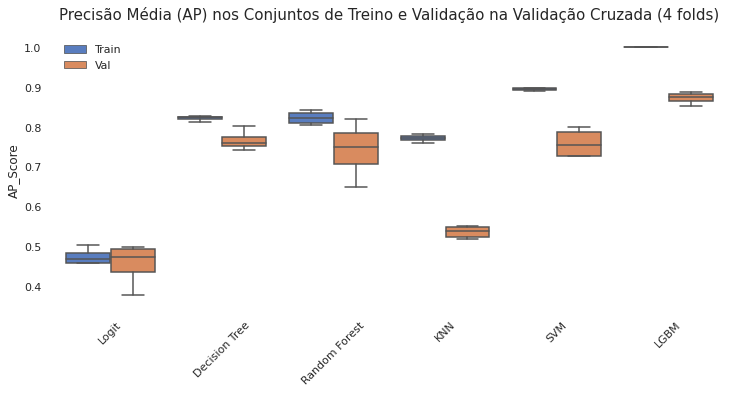

In [ ]:
fig, ax = plt.subplots(figsize = (12,5))

sns.boxplot(data = df_AP_box, x ="Modelo", y = "AP_Score", hue = "Train_Test", ax = ax)
ax.set_xlabel("")
ax.set_title("Precisão Média (AP) nos Conjuntos de Treino e Validação na Validação Cruzada (4 folds)", size = 15, pad=15)
plt.xticks(rotation = 45)
L = ax.legend()
L.get_texts()[1].set_text("Val")
L.set_title("");

In [ ]:
df_metrics_box = df_scores[["test_f1","test_recall","test_precision"]].reset_index().melt("index")
df_metrics_box.rename(columns = {"index":"Modelo", "variable": "Metric"}, inplace = True)
df_metrics_box.Metric = df_metrics_box.Metric.apply(lambda x: str(x)[x.find("_")+1:]) 
df_metrics_box.head() 

,Modelo,Metric,value
0,Logit,f1,0.298137
1,Logit,f1,0.219512
2,Logit,f1,0.349398
3,Logit,f1,0.329412
4,Decision Tree,f1,0.704225


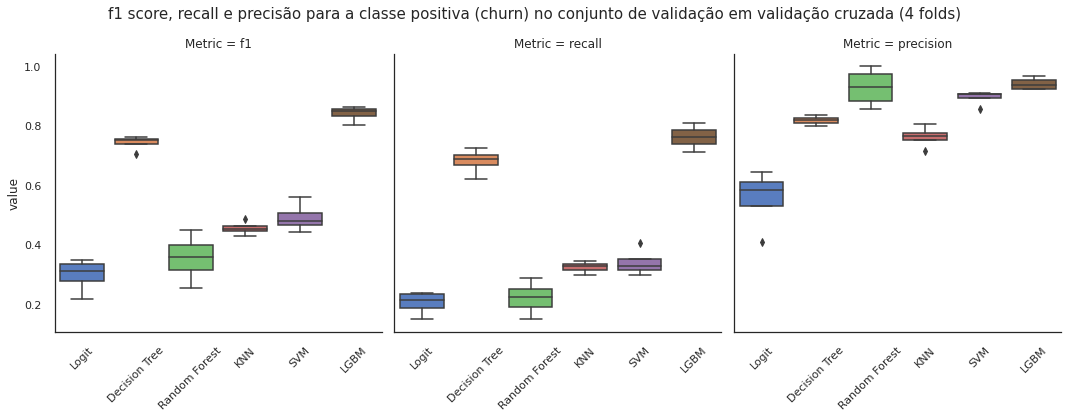

In [ ]:
g = sns.catplot(data = df_metrics_box, x = "Modelo", y= "value", kind = "box", col = "Metric")
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel("")

g.fig.suptitle("f1 score, recall e precisão para a classe positiva (churn) no conjunto de validação em validação cruzada (4 folds)", y = 1.05, size = 15);  

In [ ]:
df_metrics_heatmap = df_scores[["test_average_precision","test_f1","test_recall","test_precision"]].reset_index().groupby("index").mean()
df_metrics_heatmap.rename(columns = {"test_average_precision": "AP","test_f1":"f1","test_recall":"recall","test_precision":"precision"}, inplace = True)
df_metrics_heatmap.head()

,AP,f1,recall,precision
index,,,,
Decision Tree,0.767636,0.742947,0.681164,0.818870
KNN,0.538410,0.455539,0.325069,0.763160
LGBM,0.873828,0.841698,0.761880,0.941624
Logit,0.458719,0.299115,0.204855,0.556241
Random Forest,0.742922,0.355928,0.221384,0.929167


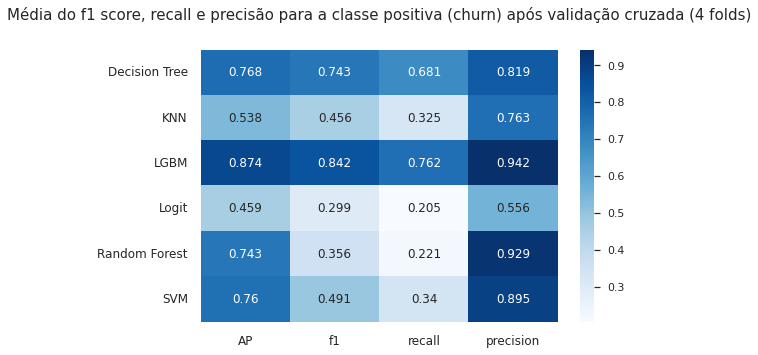

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
sns.heatmap(df_metrics_heatmap, cmap = "Blues", annot = True, ax = ax, annot_kws = dict(size = 12), fmt='.3g')
ax.set_ylabel("");
ax.set_xticklabels(ax.get_xticklabels(),size = 12)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_title("Média do f1 score, recall e precisão para a classe positiva (churn) após validação cruzada (4 folds)", size = 15, pad=30);

A DT e o LGBM foram os únicos modelos que apresentaram um alto recall em relação aos demais. Além disso, os valores de AP score, f1 e precision também foram satisfatóros. 

## Com Feature Enginering

Iremos realizar o mesmo procedeimento anterior, agora com a adição das seguinetes features: 

- recharge_total: cobrança total de chamadas em todos os períodos do dia (total_day_charge + total_eve_charge + total_night_charge + total_intl_charge)
- minutes_total: total de minutos em todos os períodos do dia (total_day_minutes + total_eve_minutes + total_night_minutes + total_intl_minutes)
- calls_total: total de chamadas em todos os períodos do dia (total_day_calls + total_eve_calls + total_night_calls + total_intl_calls)
- rechargesPerMinute: cobrança por minuto gerada por cada cliente (charge_total / minutes_total)
- plan: combinação dos planos adquiridos (Nenhum, Apenas Correio de Voz, Apenas Internacional ou Ambos)


In [ ]:
models = {}
models["Logit"] = LogisticRegression(random_state = 42)
models["Decision Tree"] = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)
models["Random Forest"] = RandomForestClassifier(n_estimators=300,min_samples_leaf=20, max_depth=5, random_state=42)
models["KNN"] = KNeighborsClassifier()
models["SVM"] = SVC(kernel="poly", degree=3, probability=True, random_state=42, C=0.25)
models["LGBM"] = LGBMClassifier(random_state = 42)

In [ ]:
#Unindo treino e teste apenas para criar as novas features em uma únca etapa
df = pd.concat([train,test], axis = 0).reset_index(drop=True)

#raindo novas features
df["recharge_total"] = df[[i for i in train.columns if "charge" in i]].sum(axis = 1)
df["minutes_total"] = df[[i for i in train.columns if "minutes" in i]].sum(axis = 1)
df["calls_total"] = df[[i for i in train.columns if "calls" in i]].sum(axis = 1)
df["rechargesPerMinute"] = df["recharge_total"] / df["minutes_total"]

def label(row):
    if (row["international_plan"] == 0) and (row["voice_mail_plan"] == 0):
        return "Nenhum"
    
    if (row["international_plan"] == 1) and (row["voice_mail_plan"] == 0):
        return "Apenas Internacional"
    
    if (row["international_plan"] == 0) and (row["voice_mail_plan"] == 1):
        return "Apenas Correio de Voz"
    else:
        return "Ambos"

df["plan"] = df.apply (lambda row: label(row), axis=1)

In [ ]:
# Separando treino e teste novamente, agora com a presença das novas features
train_FE = df.iloc[:3333,:]
test_FE = df.iloc[3333:,:].reset_index(drop = True)

#Separando features preditoras da target
X_train_FE = train_FE.drop("churn", axis = 1)
y_train_FE = train_FE["churn"]

X_test_FE = test_FE.drop("churn", axis = 1)
y_test_FE = test_FE["churn"]

In [ ]:
#Atualizando pipeline de pré-processaento para considerar as novas features
to_hashing = ["state"]
to_OHE = ["area_code", "plan"]
num_cols = X_train_FE.select_dtypes(include = np.number).columns.to_list()

ct = make_column_transformer(
    
    (OneHotEncoder(), to_OHE),
    (HashingEncoder(), to_hashing),
    (StandardScaler(), num_cols)
    
)

In [ ]:
#aplicando a validação cruzada
CV_scores_FE = {}

start = time.time()
for name, model in models.items():

    final_pipe = make_pipeline(ct, model)
    CV_score_FE = cross_validation(X_train_FE, y_train_FE, 4, final_pipe)

    CV_scores_FE[name] = CV_score_FE
end = time.time()
print(f"Tempo de execução: {end - start:.2f} segundos")

Tempo de execução: 201.79 segundos


In [ ]:
#verificando formato do resultado
CV_scores_FE["KNN"]

{'fit_time': array([1.79263568, 1.77691865, 1.77582312, 1.79950953]),
 'score_time': array([1.2252183 , 1.25834751, 1.23318386, 1.20226908]),
 'test_average_precision': array([0.59637439, 0.56117671, 0.59040002, 0.61028152]),
 'test_f1': array([0.53333333, 0.51933702, 0.52459016, 0.53631285]),
 'test_precision': array([0.81355932, 0.7704918 , 0.77419355, 0.82758621]),
 'test_recall': array([0.39669421, 0.39166667, 0.39669421, 0.39669421]),
 'train_average_precision': array([0.77816902, 0.80526758, 0.78417141, 0.80324558]),
 'train_f1': array([0.6427289 , 0.67364747, 0.64285714, 0.66431095]),
 'train_precision': array([0.91794872, 0.91904762, 0.90909091, 0.92156863]),
 'train_recall': array([0.49447514, 0.53168044, 0.49723757, 0.51933702])}

In [ ]:
#convertendo em um formato ideal para visualização
df_scores_FE = pd.DataFrame(CV_scores_FE).T.apply(pd.Series.explode)
df_scores_FE.head()

,fit_time,score_time,test_average_precision,train_average_precision,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
Logit,2.125364,1.083231,0.56502,0.545375,0.373494,0.422053,0.256198,0.30663,0.688889,0.676829
Logit,1.850125,1.071944,0.462557,0.578062,0.366667,0.442344,0.275,0.322314,0.55,0.704819
Logit,2.080849,0.86464,0.571975,0.531015,0.418605,0.378168,0.297521,0.267956,0.705882,0.642384
Logit,2.049025,0.892632,0.525372,0.550908,0.390805,0.400771,0.280992,0.287293,0.641509,0.66242
Decision Tree,2.026306,0.837511,0.855828,0.899266,0.904977,0.919403,0.826446,0.850829,1.0,1.0


In [ ]:
#convertendo dataframe para visualização em boxplot
df_AP_box_FE = df_scores_FE[["train_average_precision","test_average_precision"]].reset_index().melt("index")
df_AP_box_FE.rename(columns = {"index":"Modelo", "variable":"Train_Test", "value":"AP_Score"}, inplace = True)
df_AP_box_FE["Train_Test"] = df_AP_box_FE["Train_Test"].apply(lambda x: str(x)[:x.find("_")].capitalize())
df_AP_box_FE.head()

,Modelo,Train_Test,AP_Score
0,Logit,Train,0.545375
1,Logit,Train,0.578062
2,Logit,Train,0.531015
3,Logit,Train,0.550908
4,Decision Tree,Train,0.899266


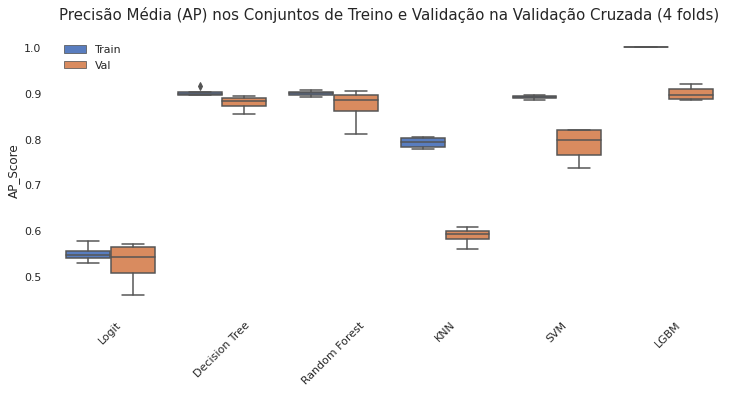

In [ ]:
fig, ax = plt.subplots(figsize = (12,5))

sns.boxplot(data = df_AP_box_FE, x ="Modelo", y = "AP_Score", hue = "Train_Test", ax = ax)
ax.set_xlabel("")
ax.set_title("Precisão Média (AP) nos Conjuntos de Treino e Validação na Validação Cruzada (4 folds)", size = 15, pad=15)
plt.xticks(rotation = 45)
L = ax.legend()
L.get_texts()[1].set_text("Val")
L.set_title("");

In [ ]:
df_metrics_box_FE = df_scores_FE[["test_f1","test_recall","test_precision"]].reset_index().melt("index")
df_metrics_box_FE.rename(columns = {"index":"Modelo", "variable": "Metric"}, inplace = True)
df_metrics_box_FE.Metric = df_metrics_box_FE.Metric.apply(lambda x: str(x)[x.find("_")+1:]) 
df_metrics_box_FE.head() # cria coluna aqui sem fe

,Modelo,Metric,value
0,Logit,f1,0.373494
1,Logit,f1,0.366667
2,Logit,f1,0.418605
3,Logit,f1,0.390805
4,Decision Tree,f1,0.904977


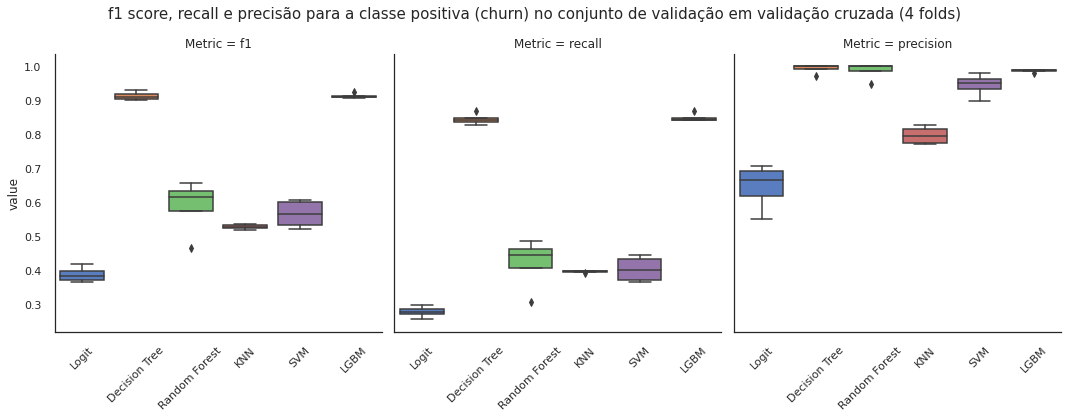

In [ ]:
g = sns.catplot(data = df_metrics_box_FE, x = "Modelo", y= "value", kind = "box", col = "Metric")
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel("")


#g.fig.subplots_adjust(top=2) # adjust the Figure in rp
g.fig.suptitle("f1 score, recall e precisão para a classe positiva (churn) no conjunto de validação em validação cruzada (4 folds)", y = 1.05, size = 15);  

In [ ]:
df_metrics_heatmap_FE = df_scores_FE[["test_average_precision","test_f1","test_recall","test_precision"]].reset_index().groupby("index").mean()
df_metrics_heatmap_FE.rename(columns = {"test_average_precision":"AP","test_f1":"f1","test_recall":"recall","test_precision":"precision"}, inplace = True)
df_metrics_heatmap_FE.head()

,AP,f1,recall,precision
index,,,,
Decision Tree,0.878795,0.912691,0.844714,0.992788
KNN,0.589558,0.528393,0.395437,0.796458
LGBM,0.899681,0.913100,0.848846,0.987956
Logit,0.531231,0.387392,0.277428,0.646570
Random Forest,0.871614,0.588790,0.422125,0.987179


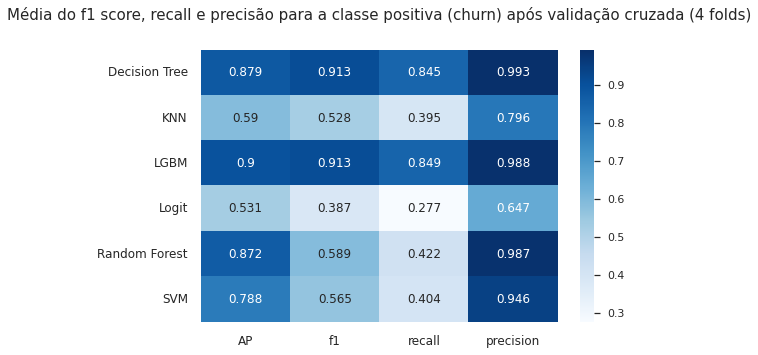

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
sns.heatmap(df_metrics_heatmap_FE, cmap = "Blues", annot = True, ax = ax, annot_kws = dict(size = 12),  fmt='.3g')
ax.set_ylabel("");
ax.set_xticklabels(ax.get_xticklabels(),size = 12)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_title("Média do f1 score, recall e precisão para a classe positiva (churn) após validação cruzada (4 folds)", size = 15, pad=30);

- a DT e o LGBM foram os únicos modelos que apresentaram um alto recall (> 0.8).

## Comparativo

In [ ]:
df_scores_comp_0 = df_scores[["test_f1","test_recall","test_precision"]].reset_index().melt("index")
df_scores_comp_0["FE"] = "NO"

df_scores_comp_1 = df_scores_FE[["test_f1","test_recall","test_precision"]].reset_index().melt("index")
df_scores_comp_1["FE"] = "YES"

df_scores_comp = pd.concat([df_scores_comp_0, df_scores_comp_1], axis = 0).reset_index(drop = True)
df_scores_comp["variable"] = df_scores_comp["variable"].apply(lambda x: str(x)[x.find("_")+1:])
df_scores_comp.rename(columns = {"variable":"Metric"}, inplace = True)

df_scores_comp.head()

,index,Metric,value,FE
0,Logit,f1,0.298137,NO
1,Logit,f1,0.219512,NO
2,Logit,f1,0.349398,NO
3,Logit,f1,0.329412,NO
4,Decision Tree,f1,0.704225,NO


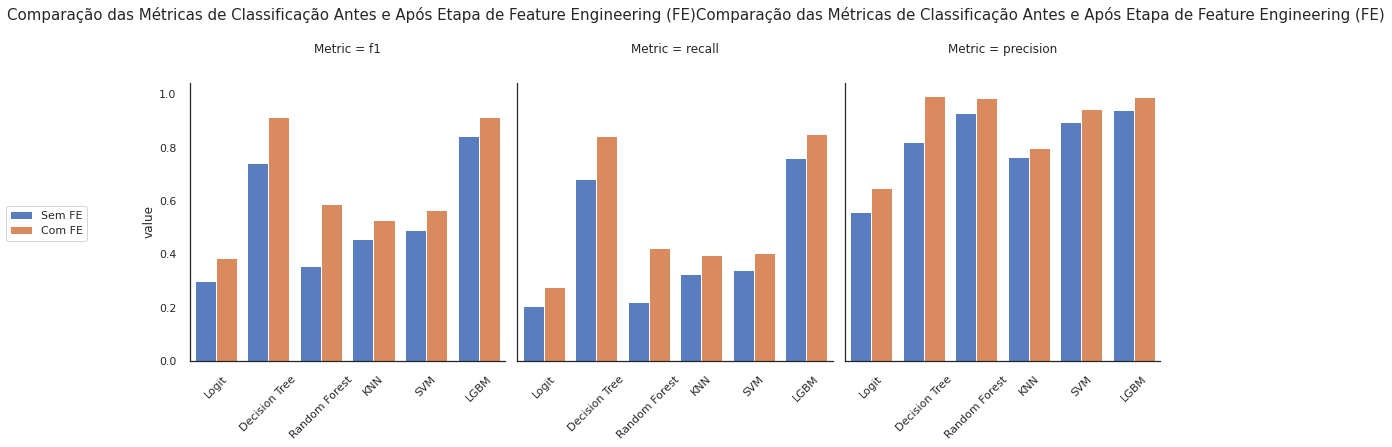

In [ ]:
g = sns.catplot(kind = "bar", data = df_scores_comp, x = "index", y = "value", col = "Metric", hue = "FE", ci = None, legend_out = True, margin_titles = True)

for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(ax.get_title(), pad = 30)
    ax.set_xlabel("")

g._legend.set_title("")
g._legend.texts[0].set_text("Sem FE")
g._legend.texts[1].set_text("Com FE")
sns.move_legend(g, "center left")

g.fig.suptitle("Comparação das Métricas de Classificação Antes e Após Etapa de Feature Engineering (FE)""Comparação das Métricas de Classificação Antes e Após Etapa de Feature Engineering (FE)", y = 1.13, size = 15);  


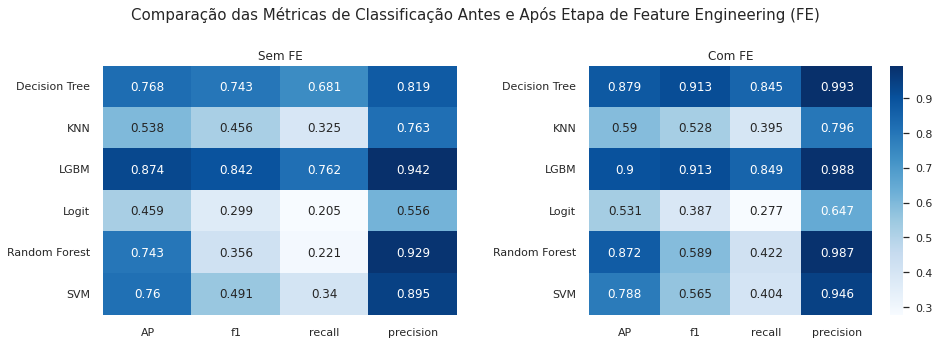

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (14,5))
sns.heatmap(df_metrics_heatmap, cmap = "Blues", annot = True, ax = ax.flat[0], annot_kws = dict(size = 12), cbar = False, fmt='.3g')
sns.heatmap(df_metrics_heatmap_FE, cmap = "Blues", annot = True, ax = ax.flat[1], annot_kws = dict(size = 12), fmt='.3g')

ax.flat[0].set(xlabel = "", ylabel = "", title = "Sem FE")
ax.flat[1].set(xlabel = "", ylabel = "", title = "Com FE")

fig.suptitle("Comparação das Métricas de Classificação Antes e Após Etapa de Feature Engineering (FE)", y = 1.02, size = 15)

fig.tight_layout(pad = 3)

-  A adição das novas features melhorou as métricas de avaliação em todos os modelos
- LGBM e DT foram os melhores modelos para o atual conjunto de dados após validação cruzada.


# Otimizando Modelos

Dos modelos candidatos, 2 se sobressairam (LGBM e DT). Tentarei otimizá-los cm as etapas de Feature Selection e Tunning de Hiperparâmetros.

## LGBM

### Feature Selection

Para Features Selection foi utilizado o método Boruta com o SHAP como pontuação das importância das features, implementado no pacote BorutaSHAP.

In [ ]:
X_train["plan"] = X_train["plan"].astype("category")
X_train["state"] = X_train["state"].astype("category")
X_train["area_code"] = X_train["area_code"].astype("category")

X_test["plan"] = X_test["plan"].astype("category")
X_test["state"] = X_test["state"].astype("category")
X_test["area_code"] = X_test["area_code"].astype("category")

In [ ]:
cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state=42)

for n, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train),1):
    X_tr, y_tr = X_train.iloc[tr_idx,:], y_train[tr_idx]
    X_val, y_val = X_train.iloc[val_idx,:], y_train[val_idx]

    #scaler iterativo em cada fold (apenas das fetaures numéricas)
    #as categoricas o LGBM irá lidar automaticamente
    scal = StandardScaler()
    X_tr_scal = X_tr.copy()
    X_tr_scal[num_cols] = scal.fit_transform(X_tr[num_cols])
    X_val_scal = X_val.copy()
    X_val_scal[num_cols] = scal.transform(X_val[num_cols])

    lgbm = LGBMClassifier(random_state = 42, verbose=-1 )

    Feature_Selector = BorutaShap(model=lgbm,
                              importance_measure='shap',
                              classification=True)

    print(f"\n\nFold {n}, train_size: {X_tr_scal.shape}, val_size: {X_val_scal.shape}")
    Feature_Selector.fit(X_tr_scal, y_tr, verbose=-1, n_trials = 100)

    #isolando features consideradas importante pelo boruta
    subset = Feature_Selector.Subset().columns

    lgbm.fit(X_tr_scal[subset], y_tr, verbose=-1)

    y_prob = lgbm.predict_proba(X_val_scal[subset])[:,1]
    y_hat = lgbm.predict(X_val_scal[subset])

    ap = average_precision_score(y_val, y_prob)
    f1 = f1_score(y_val,y_hat)
    recall = recall_score(y_val, y_hat)
    precision = precision_score(y_val, y_hat)

    print(f"AP: {ap}")
    print(f"f1: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")



Fold 1, train_size: (2499, 24), val_size: (834, 24)


  0%|          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['recharge_total', 'total_day_minutes', 'voice_mail_plan', 'total_intl_minutes', 'international_plan', 'number_customer_service_calls', 'total_intl_calls']
16 attributes confirmed unimportant: ['rechargesPerMinute', 'calls_total', 'number_vmail_messages', 'total_eve_minutes', 'area_code', 'total_eve_calls', 'total_day_calls', 'state', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_intl_charge', 'total_night_charge', 'plan', 'minutes_total', 'total_day_charge']
1 tentative attributes remains: ['account_length']
AP: 0.8605318354880855
f1: 0.9066666666666666
Recall: 0.8429752066115702
Precision: 0.9807692307692307


Fold 2, train_size: (2500, 24), val_size: (833, 24)


  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['recharge_total', 'voice_mail_plan', 'state', 'international_plan', 'number_customer_service_calls', 'total_intl_calls']
16 attributes confirmed unimportant: ['rechargesPerMinute', 'calls_total', 'account_length', 'number_vmail_messages', 'total_eve_minutes', 'area_code', 'total_day_minutes', 'total_eve_calls', 'total_day_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_intl_charge', 'total_night_charge', 'plan', 'total_day_charge']
2 tentative attributes remains: ['minutes_total', 'total_intl_minutes']
AP: 0.8404859134038507
f1: 0.8285714285714285
Recall: 0.725
Precision: 0.9666666666666667


Fold 3, train_size: (2500, 24), val_size: (833, 24)


  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['recharge_total', 'voice_mail_plan', 'total_intl_minutes', 'international_plan', 'number_customer_service_calls', 'total_intl_calls']
18 attributes confirmed unimportant: ['rechargesPerMinute', 'calls_total', 'account_length', 'number_vmail_messages', 'total_eve_minutes', 'area_code', 'total_day_minutes', 'total_eve_calls', 'total_day_calls', 'state', 'total_eve_charge', 'total_night_calls', 'total_night_minutes', 'total_intl_charge', 'total_night_charge', 'plan', 'minutes_total', 'total_day_charge']
0 tentative attributes remains: []
AP: 0.9040430481375268
f1: 0.908296943231441
Recall: 0.859504132231405
Precision: 0.9629629629629629


Fold 4, train_size: (2500, 24), val_size: (833, 24)


  0%|          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['recharge_total', 'total_eve_minutes', 'voice_mail_plan', 'total_intl_minutes', 'international_plan', 'number_customer_service_calls', 'total_intl_calls']
16 attributes confirmed unimportant: ['rechargesPerMinute', 'calls_total', 'account_length', 'number_vmail_messages', 'area_code', 'total_day_minutes', 'total_eve_calls', 'total_day_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_intl_charge', 'total_night_charge', 'plan', 'minutes_total', 'total_day_charge']
1 tentative attributes remains: ['state']
AP: 0.9167819745870772
f1: 0.9251101321585904
Recall: 0.8677685950413223
Precision: 0.9905660377358491


O fold 4 foi o que apresentou a mehor métrica. Irei testar os 7 atributos consderados importante nesse fold em todo o conjunto de treino com a validação cruzada

In [ ]:
#montando treino e teste com features consideradas importante pelo BorutaSHAP no fold 4
lgbm_boruta_cols = ['recharge_total', 'total_eve_minutes', 'voice_mail_plan', 'total_intl_minutes', 'international_plan', 'number_customer_service_calls', 'total_intl_calls']
X_train_lgbm_boruta = X_train[lgbm_boruta_cols]
X_test_lgbm_boruta = X_test[lgbm_boruta_cols]

In [ ]:
lgbm_pipe = make_pipeline(StandardScaler(), LGBMClassifier(random_state = 42))
r = cross_validation(X_train_lgbm_boruta, y_train, 4, lgbm_pipe)

In [ ]:
#CV_boruta
np.mean(r["test_average_precision"]), np.mean(r["test_f1"]), np.mean(r["test_recall"])

(0.8988929767497553, 0.912313502930243, 0.8509125344352617)

In [ ]:
lgbm_metrics = pd.DataFrame({"Raw":[0.873828, 0.841698, 0.761880],
                             "FE": [0.899681,0.913100, 0.848846 ],
                             "FE+FS":[0.898892, 0.912313, 0.850912]}, index=["AP","F1","Recall"])
lgbm_metrics

,Raw,FE,FE+FS
AP,0.873828,0.899681,0.898892
F1,0.841698,0.913100,0.912313
Recall,0.761880,0.848846,0.850912


O método BorutaSHAP se mostrou eficaz uma vez que foi possível reuzir o número de features de 24 para 7 com uma pequena melhoria nas métricas. Irei ajustar os hiperparametros com base nesse subconjunto de features para verificar se é possível obter mais melhorias.




### Tunning

In [ ]:
from optuna.integration import LightGBMPruningCallback

In [ ]:
def objective_LGBM(trial, X, y ):

    param_grid = {
    "metric":"average_precision",
    "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
    "max_depth": trial.suggest_int("max_depth", 3, 12),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 1000, step=20),
    "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
    "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
    }


    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    cv_scores = []

    for tr_idx,val_idx in cv.split(X,y):
    scaler = StandardScaler()

    X_tr, y_tr = X.iloc[tr_idx,:], y[tr_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]

    X_tr_scal = scaler.fit_transform(X_tr)
    X_val_scal = scaler.transform(X_val)

    model = LGBMClassifier(objective="binary", verbose = -1,  **param_grid)
    model.fit(X_tr_scal,
    y_tr,
    eval_set=[(X_val_scal,y_val)],
    early_stopping_rounds=150,
    eval_metric="average_precision",
    verbose = -1,
    #Callback para LightGBM "podar" tentativas não promissoras.
    callbacks=[LightGBMPruningCallback(trial, "average_precision")]
    )

    y_prob = model.predict_proba(X_val_scal)[:,1]
    cv_score = average_precision_score(y_val, y_prob)
    cv_scores.append(cv_score)

    return np.mean(cv_scores)


In [ ]:
start = time.time()
sampler = TPESampler(seed=10)
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier", sampler = sampler)
func = lambda trial: objective_LGBM(trial, X_train_lgbm_boruta, y_train)
study.optimize(func, n_trials=300)
end = time.time()
print("#"*100)
print(f"Tempo de execução {(start - end):.2f} segundos")

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
#mostrando melhor conjunto de hiperparametros encontrado
print(f"\tBest value (AP): {study.best_value:.5f}")
print(f"\tBest params:")


params_lgbm = study.best_params

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AP): 0.90435
	Best params:
		n_estimators: 10000
		learning_rate: 0.27140590028960937
		num_leaves: 480
		max_depth: 3
		min_data_in_leaf: 80
		lambda_l1: 0
		lambda_l2: 25


In [ ]:
lgbm_pipe = make_pipeline(StandardScaler(), LGBMClassifier(random_state = 42, **params_lgbm))
r, c = cross_validation(X_train_lgbm_boruta, y_train, 4, model = lgbm_pipe )

In [ ]:
#cv: FE + FS + tunning 
np.mean(r["test_average_precision"]), np.mean(r["test_f1"]), np.mean(r["test_recall"]) #tunning - cv

(0.9030005988983035, 0.9026194993753978, 0.8550275482093663)

In [ ]:
lgbm_metrics["FE+FS+TUN"] = [0.903000, 0.902619,0.855027]
lgbm_metrics

,Raw,FE,FE+FS,FE+FS+TUN
AP,0.873828,0.899681,0.898892,0.903000
F1,0.841698,0.913100,0.912313,0.902619
Recall,0.761880,0.848846,0.850912,0.855027


Conseguimos mais umpequeno aumento no recall e f1-score com a etapa de tunning

In [ ]:
params_lgbm

{'lambda_l1': 0,
 'lambda_l2': 25,
 'learning_rate': 0.27140590028960937,
 'max_depth': 3,
 'min_data_in_leaf': 80,
 'n_estimators': 10000,
 'num_leaves': 480}

In [ ]:
#salvando combinação de hiperparâmeros
params_lgbm = {'lambda_l1': 0,
 'lambda_l2': 25,
 'learning_rate': 0.27140590028960937,
 'max_depth': 3,
 'min_data_in_leaf': 80,
 'n_estimators': 10000,
 'num_leaves': 480}

### Interpretando as previsões

In [ ]:
lgbm_boruta_cols = ['recharge_total', 'total_eve_minutes', 'voice_mail_plan', 'total_intl_minutes', 'international_plan', 'number_customer_service_calls', 'total_intl_calls']

In [ ]:
scaler = StandardScaler()
X_train_lgbm_boruta = X_train[lgbm_boruta_cols]
X_test_lgbm_boruta = X_test[lgbm_boruta_cols]

X_train_lgbm_boruta_scal = pd.DataFrame(scaler.fit_transform(X_train_lgbm_boruta), columns = X_train_lgbm_boruta.columns)
X_test_lgbm_boruta_scal = pd.DataFrame(scaler.transform(X_test_lgbm_boruta), columns = X_test_lgbm_boruta.columns)


In [ ]:
lgbm = LGBMClassifier(random_state = 42, **params_lgbm)
lgbm.fit(X_train_lgbm_boruta_scal, y_train)

[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


LGBMClassifier(lambda_l1=0, lambda_l2=25, learning_rate=0.27140590028960937,
               max_depth=3, min_data_in_leaf=80, n_estimators=10000,
               num_leaves=480, random_state=42)

Não consegui usar shap.Explainer(model) como exemplificado aqui. Talvez seja algum problema de compatibilidade com LGBM tendo em vista que com o XGBoost funcional. Dessa forma, tive que utilizar o TreeExplainer


In [ ]:
#force
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train_lgbm_boruta_scal)

shap_values_plot = explainer(X_train_lgbm_boruta_scal)
shap_values_plot_format = cpy.deepcopy(shap_values_plot)
shap_values_plot_format.values = shap_values_plot_format.values[:,:,1]
shap_values_plot_format.base_values = shap_values_plot_format.base_values[:,1]

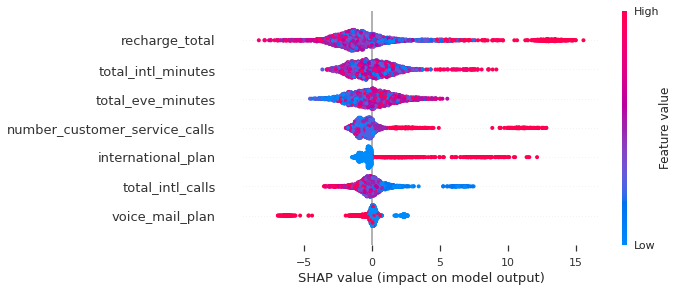

In [ ]:
shap.plots.beeswarm(shap_values_plot_format)

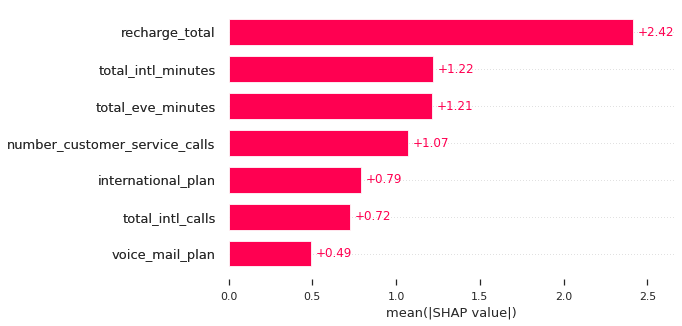

In [ ]:
shap.plots.bar(shap_values_plot_format)

#### Interpretação Local

In [ ]:
#1 é a classe 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][10], link = "logit", features = X_train_lgbm_boruta_scal.columns)

In [ ]:
#1 é a classe 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][2], link = "logit", features = X_train_lgbm_boruta_scal.columns)

Novos dados

In [ ]:
lgbm_pipe = make_pipeline(StandardScaler(), LGBMClassifier(random_state = 42, **params_lgbm))
lgbm_pipe.fit(X_train_lgbm_boruta, y_train)

[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(lambda_l1=0, lambda_l2=25,
                                learning_rate=0.27140590028960937, max_depth=3,
                                min_data_in_leaf=80, n_estimators=10000,
                                num_leaves=480, random_state=42))])

In [ ]:
new_input_1 = np.array([3, 200,9, 50,10,0,0]).reshape((1,-1))
new_input_1_scal = lgbm_pipe[0].transform(new_input_1)

In [ ]:
lgbm.predict_proba(new_input_1_scal)[:,1]

array([0.99953933])

In [ ]:
#scal pq o explainer foi com lgbm sem pipe
shap_new = explainer.shap_values(new_input_1_scal)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_new[1], link = "logit", features = X_train_lgbm_boruta_scal.columns)

In [ ]:
shap.initjs()
new_input_2 = np.array([500, 23,56, 1,1,0,0]).reshape((1,-1))
new_input_2_scal = lgbm_pipe[0].transform(new_input_2)
shap_new2 = explainer.shap_values(new_input_2_scal)
shap.force_plot(explainer.expected_value[1], shap_new2[1], link = "logit", features = X_train_lgbm_boruta_scal.columns)


### Avaliação Final em Teste

Calibrando probabilidades

In [ ]:
X_train_lgbm_boruta = X_train[['total_intl_calls', 'recharge_total', 'number_customer_service_calls', 'total_eve_minutes', 'total_intl_minutes', 'voice_mail_plan', 'international_plan']]
X_test_lgbm_boruta = X_test[['total_intl_calls', 'recharge_total', 'number_customer_service_calls', 'total_eve_minutes', 'total_intl_minutes', 'voice_mail_plan', 'international_plan']]
                       
lgbm_pipe = make_pipeline(StandardScaler(), CalibratedClassifierCV(LGBMClassifier(random_state = 42, **params_lgbm), cv = 10))
lgbm_pipe.fit(X_train_lgbm_boruta, y_train)

y_prob = lgbm_pipe.predict_proba(X_test_lgbm_boruta)[:,1]
y_hat = lgbm_pipe.predict(X_test_lgbm_boruta)


In [ ]:
average_precision_score(y_test, y_prob),  f1_score(y_test, y_hat), recall_score(y_test, y_hat) # test calibrated

(0.906569973672866, 0.9142857142857143, 0.8571428571428571)

In [ ]:
lgbm_metrics["TEST"]= [0.906569,  0.914285, 0.857142]
lgbm_metrics

,Raw,FE,FE+FS,FE+FS+TUN,TEST
AP,0.873828,0.899681,0.898892,0.903000,0.906569
F1,0.841698,0.913100,0.912313,0.902619,0.914285
Recall,0.761880,0.848846,0.850912,0.855027,0.857142


A avaliação em teste está bem próxima a observada na validação cruzada. É possível concluir que o modelo está generalizando bem 

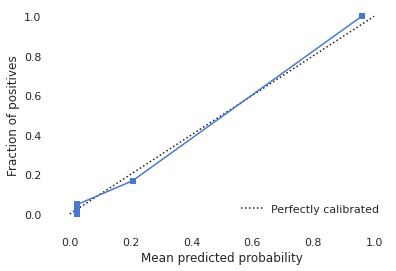

In [ ]:
y_prob = lgbm_pipe.predict_proba(X_test_lgbm_boruta)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy = "quantile")
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot();

As probabilidades estão calibradas

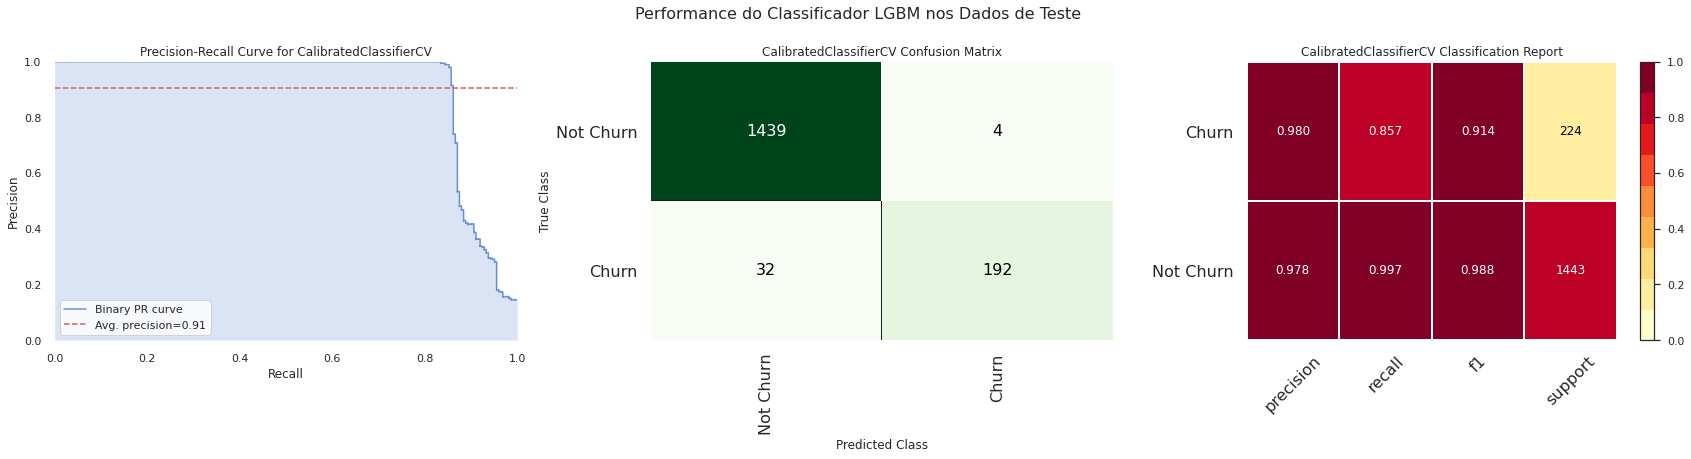

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (24,6)) ##22,6

#precision-recall curve
viz = PrecisionRecallCurve(lgbm_pipe, is_fitted=True, fontsize = 16, ax = ax.flat[0])
viz.fit(X_train_lgbm_boruta, y_train)
viz.score(X_test_lgbm_boruta, y_test)

#confusion matrix
classes = ["Not Churn", "Churn"]
cm = ConfusionMatrix(lgbm_pipe, classes=classes, label_encoder={0: 'Not Churn', 1: 'Churn'}, cmap = "Greens", is_fitted = True, fontsize = 16, ax = ax.flat[1])
cm.score(X_test_lgbm_boruta, y_test)

#classification report
visualizer = ClassificationReport(lgbm_pipe, classes=classes, support=True, fontsize = 16, is_fitted = True, ax = ax.flat[2])
visualizer.score(X_test_lgbm_boruta, y_test)       

fig.tight_layout(pad=3)
fig.suptitle("Performance do Classificador LGBM nos Dados de Teste", size = 16, y = 1.06)

visualizer.finalize() 
viz.finalize()
cm.finalize()
plt.savefig('LHGBM_ML.png', dpi = 50,  bbox_inches='tight');


### Treinando Modelo Final

In [ ]:
X = pd.concat([X_train_lgbm_boruta, X_test_lgbm_boruta]).reset_index(drop = True)
y = pd.concat([y_train,y_test]).reset_index(drop = True)

In [ ]:
final_lgbm_model = make_pipeline(StandardScaler(), CalibratedClassifierCV(LGBMClassifier(random_state = 42, **params_lgbm), cv = 10))
final_lgbm_model.fit(X,y)

[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l2 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(base_estimator=LGBMClassifier(lambda_l1=0,
                                                                      lambda_l2=25,
                                                                      learning_rate=0.27140590028960937,
                                                                      max_depth=3,
                                                                      min_data_in_leaf=80,
                                                                      n_estimators=10000,
                                                                      num_leaves=480,
                                                                      random_state=42),
                                        cv=10))])

In [ ]:
filename = 'final_lgbm_model.sav'
pickle.dump(final_lgbm_model, open(filename, 'wb'))

In [ ]:
lgbm_model = pickle.load(open('final_lgbm_model.sav', 'rb'))

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)

### Feature Selection

In [ ]:
cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state=42)

for n, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train),1):
    X_tr, y_tr = X_train.iloc[tr_idx,:], y_train[tr_idx]
    X_val, y_val = X_train.iloc[val_idx,:], y_train[val_idx]

    #scaler iterativo em cada fold (apenas das fetaures numéricas)
    #as categoricas o LGBM irá lidar automaticamente

    dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)
    ct.fit(X_tr, y_tr)
    cols = get_feature_names(ct)

    X_tr_scal = pd.DataFrame(ct.transform(X_tr), columns = cols)
    X_val_scal = pd.DataFrame(ct.transform(X_val), columns = cols) 

    Feature_Selector = BorutaShap(model=dt,
                              importance_measure='shap',
                              classification=True)

    print(f"\n\nFold {n}, train_size: {X_tr_scal.shape}, val_size: {X_val_scal.shape}")
    Feature_Selector.fit(X_tr_scal, y_tr, n_trials = 100)

    #isolando features consideradas importante pelo boruta
    subset = Feature_Selector.Subset().columns

    dt.fit(X_tr_scal[subset], y_tr)

    y_prob = dt.predict_proba(X_val_scal[subset])[:,1]
    y_hat = dt.predict(X_val_scal[subset])

    ap = average_precision_score(y_val, y_prob)
    f1 = f1_score(y_val,y_hat)
    recall = recall_score(y_val, y_hat)
    precision = precision_score(y_val, y_hat)

    print(f"AP: {ap}")
    print(f"f1: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")



Fold 1, train_size: (2499, 36), val_size: (834, 36)


  0%|          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['standardscaler__account_length', 'standardscaler__international_plan', 'standardscaler__total_intl_charge', 'onehotencoder__plan_1', 'standardscaler__total_intl_calls', 'standardscaler__recharge_total', 'standardscaler__number_customer_service_calls']
29 attributes confirmed unimportant: ['hashingencoder__col_1', 'hashingencoder__col_4', 'hashingencoder__col_6', 'standardscaler__number_vmail_messages', 'onehotencoder__area_code_3', 'hashingencoder__col_5', 'standardscaler__total_day_calls', 'onehotencoder__area_code_1', 'standardscaler__rechargesPerMinute', 'standardscaler__total_night_charge', 'standardscaler__total_eve_minutes', 'hashingencoder__col_0', 'onehotencoder__plan_4', 'standardscaler__voice_mail_plan', 'standardscaler__total_day_charge', 'standardscaler__total_eve_charge', 'onehotencoder__plan_2', 'onehotencoder__area_code_2', 'hashingencoder__col_3', 'hashingencoder__col_7', 'standardscaler__calls_total', 'standardscaler__total_night_cal

  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['standardscaler__international_plan', 'onehotencoder__plan_1', 'standardscaler__total_intl_calls', 'standardscaler__recharge_total', 'standardscaler__number_customer_service_calls', 'standardscaler__total_intl_minutes']
29 attributes confirmed unimportant: ['hashingencoder__col_1', 'hashingencoder__col_4', 'hashingencoder__col_6', 'standardscaler__account_length', 'standardscaler__total_day_charge', 'standardscaler__total_eve_charge', 'onehotencoder__plan_2', 'standardscaler__total_intl_charge', 'standardscaler__number_vmail_messages', 'onehotencoder__area_code_2', 'onehotencoder__plan_4', 'onehotencoder__area_code_3', 'standardscaler__total_day_calls', 'hashingencoder__col_5', 'hashingencoder__col_3', 'onehotencoder__plan_3', 'onehotencoder__area_code_1', 'hashingencoder__col_7', 'standardscaler__calls_total', 'standardscaler__rechargesPerMinute', 'standardscaler__total_night_calls', 'standardscaler__total_night_charge', 'hashingencoder__col_2', 'sta

  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['standardscaler__international_plan', 'onehotencoder__plan_1', 'standardscaler__total_intl_calls', 'standardscaler__number_customer_service_calls', 'standardscaler__total_intl_minutes', 'standardscaler__recharge_total']
29 attributes confirmed unimportant: ['hashingencoder__col_1', 'hashingencoder__col_4', 'hashingencoder__col_6', 'standardscaler__account_length', 'standardscaler__total_day_charge', 'standardscaler__total_eve_charge', 'onehotencoder__plan_2', 'standardscaler__total_intl_charge', 'standardscaler__number_vmail_messages', 'onehotencoder__area_code_2', 'onehotencoder__plan_4', 'onehotencoder__area_code_3', 'standardscaler__total_day_calls', 'hashingencoder__col_5', 'hashingencoder__col_3', 'onehotencoder__plan_3', 'onehotencoder__area_code_1', 'hashingencoder__col_7', 'standardscaler__minutes_total', 'standardscaler__rechargesPerMinute', 'standardscaler__total_night_calls', 'standardscaler__total_night_charge', 'hashingencoder__col_2', 's

  0%|          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['standardscaler__international_plan', 'standardscaler__total_intl_calls', 'standardscaler__total_eve_minutes', 'standardscaler__recharge_total', 'standardscaler__number_customer_service_calls', 'standardscaler__total_intl_minutes', 'standardscaler__voice_mail_plan']
27 attributes confirmed unimportant: ['hashingencoder__col_1', 'hashingencoder__col_4', 'hashingencoder__col_6', 'onehotencoder__area_code_3', 'hashingencoder__col_5', 'standardscaler__total_day_calls', 'onehotencoder__area_code_1', 'standardscaler__rechargesPerMinute', 'standardscaler__total_night_charge', 'hashingencoder__col_0', 'onehotencoder__plan_4', 'standardscaler__total_day_charge', 'standardscaler__total_eve_charge', 'onehotencoder__plan_2', 'standardscaler__total_intl_charge', 'onehotencoder__area_code_2', 'hashingencoder__col_3', 'hashingencoder__col_7', 'standardscaler__calls_total', 'standardscaler__total_night_calls', 'hashingencoder__col_2', 'onehotencoder__plan_1', 'standa

In [ ]:
dt_boruta_cols = ['international_plan', 'total_intl_calls', 'total_eve_minutes', 'recharge_total', 'number_customer_service_calls', 'total_intl_minutes', 'voice_mail_plan']
X_train_dt_boruta = X_train[dt_boruta_cols]
X_test_dt_boruta = X_test[dt_boruta_cols]

In [ ]:
dt_pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42) )
r, c = cross_validation(X_train_dt_boruta, y_train, 4, dt_pipe)

In [ ]:
#CV FS
np.mean(r["test_average_precision"]), np.mean(r["test_f1"]), np.mean(r["test_recall"])

(0.8775426831228564, 0.9145175076893889, 0.8426308539944903)

In [ ]:
dt_metrics = pd.DataFrame({"Raw":[0.767636, 0.742947, 0.681164],
                             "FE": [0.878795,	0.912691,	0.844714 ],
                             "FE+FS":[0.877542, 0.914517, 0.842630]}, index=["AP","F1","Recall"])
dt_metrics

,Raw,FE,FE+FS
AP,0.767636,0.878795,0.877542
F1,0.742947,0.912691,0.914517
Recall,0.681164,0.844714,0.842630


### Tunning

In [ ]:
def objective_dt(trial, X, y ):


    param_grid = {
    "splitter": trial.suggest_categorical("splitter", ["best","random"]),
    "max_depth": trial.suggest_int("max_depth",1,5),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
    "class_weight": trial.suggest_categorical("class_weight",["balanced",None]),
    }

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    cv_scores = []

    for tr_idx,val_idx in cv.split(X,y):
    scaler = StandardScaler()

    X_tr, y_tr = X.iloc[tr_idx,:], y[tr_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]

    X_tr_scal = scaler.fit_transform(X_tr)
    X_val_scal = scaler.transform(X_val)

    model =  DecisionTreeClassifier(random_state=42, **param_grid)
    model.fit(X_tr_scal, y_tr)


    y_prob = model.predict_proba(X_val_scal)[:,1]
    cv_score = average_precision_score(y_val, y_prob)
    cv_scores.append(cv_score)

    return np.mean(cv_scores)


In [ ]:
start = time.time()
sampler = TPESampler(seed=10)
study = optuna.create_study(direction="maximize", study_name="Decision Tree Classifier", sampler = sampler)
func = lambda trial: objective_dt(trial, X_train_boruta, y_train)
study.optimize(func, n_trials=300)
end = time.time()
print("#"*100)
print(f"Tempo de execução {(start - end):.2f} segundos")

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
print(f"\tBest value (AP): {study.best_value:.5f}")
print(f"\tBest params:")


params_dt = study.best_params

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AP): 0.88623
	Best params:
		splitter: best
		max_depth: 5
		min_samples_leaf: 7
		class_weight: None


In [ ]:
dt_pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state = 42, **params_dt))
r, c = cross_validation(X_train_dt_boruta, y_train, 4, model = dt_pipe )

In [ ]:
np.mean(r["test_average_precision"]), np.mean(r["test_f1"]), np.mean(r["test_recall"]) #tunning - cv

(0.8862343004692615, 0.9126912089880902, 0.8447141873278237)

In [ ]:
dt_metrics["FE+FS+TUN"] = [0.886234, 0.912691, 0.844714 ]
dt_metrics

,Raw,FE,FE+FS,FE+FS+TUN
AP,0.767636,0.878795,0.877542,0.886234
F1,0.742947,0.912691,0.914517,0.912691
Recall,0.681164,0.844714,0.842630,0.844714


In [ ]:
params_dt

{'class_weight': None,
 'max_depth': 5,
 'min_samples_leaf': 7,
 'splitter': 'best'}

In [ ]:
params_dt = {'class_weight': None,
 'max_depth': 5,
 'min_samples_leaf': 7,
 'splitter': 'best'}

### Interpretando as Previsões

In [ ]:
dt = DecisionTreeClassifier(random_state = 42, **params_dt)
dt.fit(X_train_dt_boruta, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=7, random_state=42)

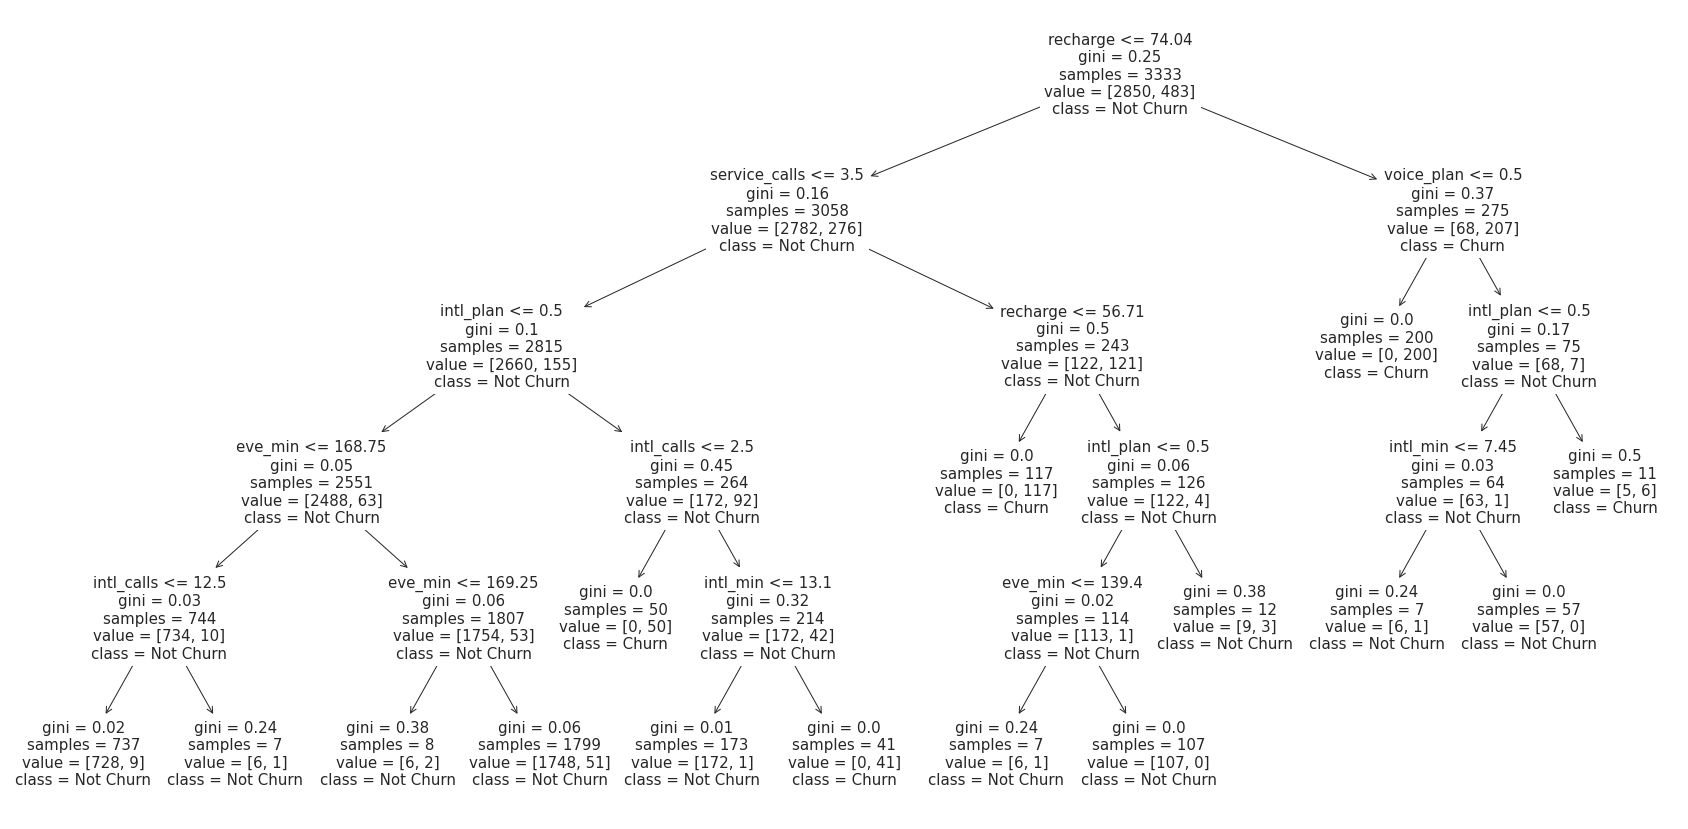

In [ ]:
fig, ax = plt.subplots(figsize = (30,15))
abrev_features = ["intl_plan", "intl_calls","eve_min","recharge","service_calls","intl_min","voice_plan"]
plot_tree(dt, max_depth = 5, fontsize = 15, ax = ax, precision = 2, feature_names = abrev_features, class_names = ["Not Churn","Churn"]);

### Avaliação Final em Teste

In [ ]:
X_train_dt_boruta = X_train[dt_boruta_cols]
X_test_dt_boruta = X_test[dt_boruta_cols]

In [ ]:
dt_pipe = make_pipeline(StandardScaler(), CalibratedClassifierCV(DecisionTreeClassifier(random_state = 42, **params_dt), cv = 10))
dt_pipe.fit(X_train_dt_boruta, y_train)


y_prob = dt_pipe.predict_proba(X_test_dt_boruta)[:,1]
y_hat = dt_pipe.predict(X_test_dt_boruta)


In [ ]:
average_precision_score(y_test, y_prob),  f1_score(y_test, y_hat), recall_score(y_test, y_hat) # test calibrated

(0.9028933871605983, 0.9108433734939758, 0.84375)

In [ ]:
dt_metrics["test"] = [0.902893, 0.910843, 0.84375 ]
dt_metrics

,Raw,FE,FE+FS,FE+FS+TUN,test
AP,0.767636,0.878795,0.877542,0.886234,0.902893
F1,0.742947,0.912691,0.914517,0.912691,0.910843
Recall,0.681164,0.844714,0.842630,0.844714,0.843750


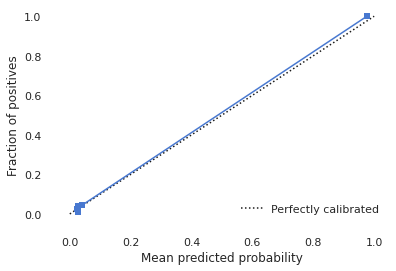

In [ ]:
y_prob = dt_pipe.predict_proba(X_test_dt_boruta)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy = "quantile")
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot();

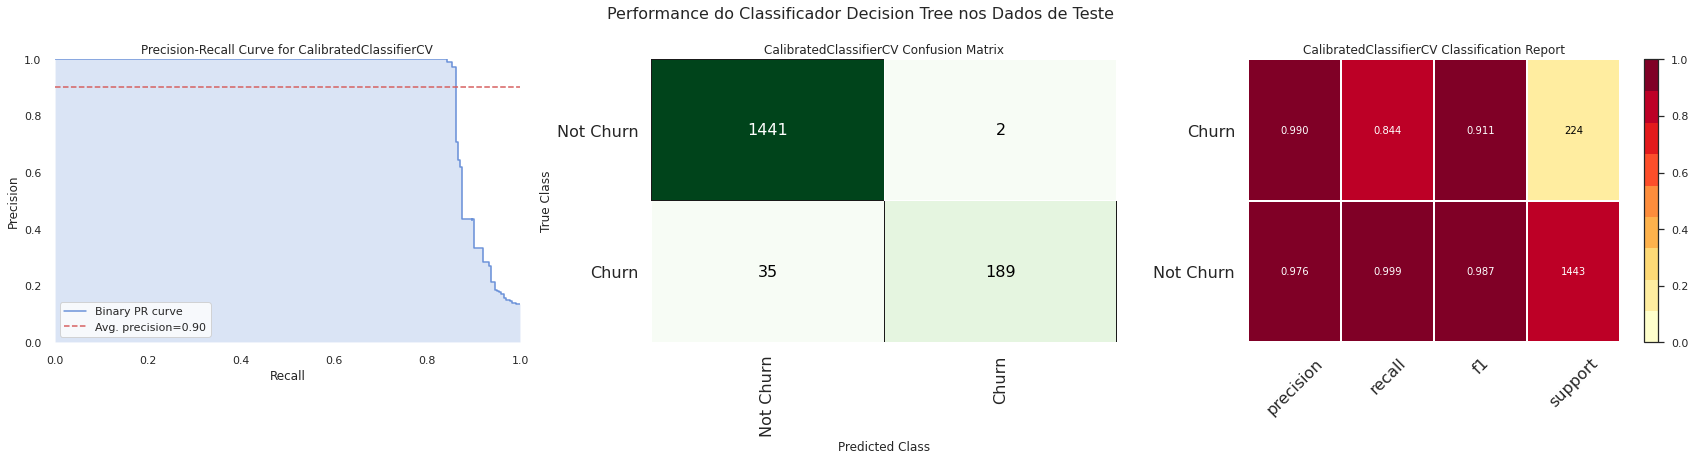

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (24,6)) ##22,6

#precision-recall curve
viz = PrecisionRecallCurve(dt_pipe, is_fitted=True, fontsize = 16, ax = ax.flat[0])
viz.fit(X_train_dt_boruta, y_train)
viz.score(X_test_dt_boruta, y_test)

#confusion matrix
classes = ["Not Churn", "Churn"]
cm = ConfusionMatrix(dt_pipe, classes=classes, label_encoder={0: 'Not Churn', 1: 'Churn'}, cmap = "Greens", is_fitted = True, fontsize = 16, ax = ax.flat[1])
cm.score(X_test_dt_boruta, y_test)

#classification report
visualizer = ClassificationReport(dt_pipe, classes=classes, support=True, fontsize = 16, is_fitted = True, ax = ax.flat[2])
visualizer.score(X_test_dt_boruta, y_test)       

fig.tight_layout(pad=3)
fig.suptitle("Performance do Classificador Decision Tree nos Dados de Teste", size = 16, y = 1.06)

visualizer.finalize() 
viz.finalize()
cm.finalize()

### Treinando Modelo Final

In [ ]:
X = pd.concat([X_train_dt_boruta, X_test_dt_boruta]).reset_index(drop = True)
y = pd.concat([y_train,y_test]).reset_index(drop = True)

In [ ]:
final_dt_model = make_pipeline(StandardScaler(), CalibratedClassifierCV(DecisionTreeClassifier(random_state = 42, **params_dt), cv = 10))
final_dt_model.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                              min_samples_leaf=7,
                                                                              random_state=42),
                                        cv=10))])

In [ ]:
filename = 'final_dt_model.sav'
pickle.dump(final_dt_model, open(filename, 'wb'))

In [ ]:
#loaded_model = pickle.load(open('final_dt_model.sav', 'rb'))

# Segmentação de Clientes 

Para segmentar o clientes em grupos, utilizei o K-means verificando o número de clusters ideais com o método de elbow. Para visuaizar os clusters em um plano 2d, reduzi a dimensionalidade com PCA. Por fim, a interpretação dos cluster se deu através de agrupamentos avaliando a média para cada grupo. 

In [ ]:
# treinando modelo com todo o conjunto de dados para obter as probabilidades
X = pd.concat([X_train_lgbm_boruta, X_test_lgbm_boruta]).reset_index(drop = True)
y = pd.concat([y_train,y_test]).reset_index(drop = True)

final_lgbm_model = make_pipeline(StandardScaler(), CalibratedClassifierCV(LGBMClassifier(random_state = 42, **params_lgbm), cv = 10))
final_lgbm_model.fit(X,y)
y_proba = final_lgbm_model.predict_proba(X)

#adicionar probabilidades ao dataframe
data = pd.concat([train, test], axis = 0).reset_index(drop = True)
data["prob"] = y_proba[:,1] 
data.head()

[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l2 

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute,plan,churn,prob
0,KS,128,area_code_415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,75.56,717.2,304,0.105354,Apenas Correio de Voz,0,0.021287
1,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,59.24,625.2,333,0.094754,Apenas Correio de Voz,0,0.021355
2,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,62.29,539.4,333,0.115480,Nenhum,0,0.021331
3,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,66.80,564.8,257,0.118272,Apenas Internacional,0,0.021285
4,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,52.09,512.0,362,0.101738,Apenas Internacional,0,0.021337


Por se tratar de um algoritmo que leva em consideração a distância matemática entre os dados, não faz sentido alimentar o KMeans com features categóricas. Logo, elas foram removidas antes do treinamento. As features restantes  foram normalizadas para o intervalo entre 0-1 afim de evitaro efeito de diferentes escalas na medida de distância.

In [ ]:
data_cluster.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute,prob
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,75.56,717.2,304,0.105354,0.021287
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,59.24,625.2,333,0.094754,0.021355
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,62.29,539.4,333,0.115480,0.021331
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,66.80,564.8,257,0.118272,0.021285
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,52.09,512.0,362,0.101738,0.021337


In [ ]:
#removendo features categóricas e normalizando os dados
data_cluster = data.drop(["international_plan", "voice_mail_plan","state", "area_code", "plan", "churn"], axis = 1)
data_cluster_scaled = MinMaxScaler().fit_transform(data_cluster)

AttributeError: ignored

TypeError: ignored

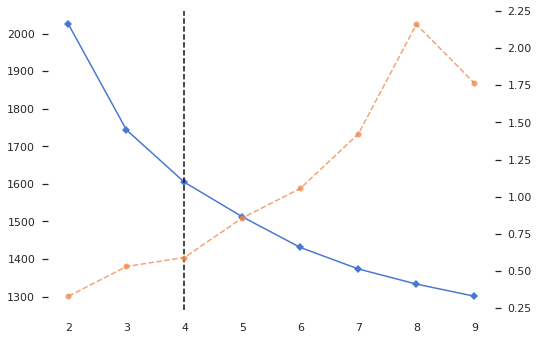

In [ ]:
#aplicando método de elbow. Não recebe como input pipeline, por isso transformei manualmete.
visualizer = KElbowVisualizer(KMeans(), k=(2,10))
visualizer.fit(data_cluster_scaled)

O número de clusters ideal foi 4

In [ ]:
#treinando kmeans com 4 clusters e obtendo os clusters
k = make_pipeline(MinMaxScaler(), KMeans(n_clusters = 4, random_state = 42))
clusters = k.fit_predict(data_cluster)

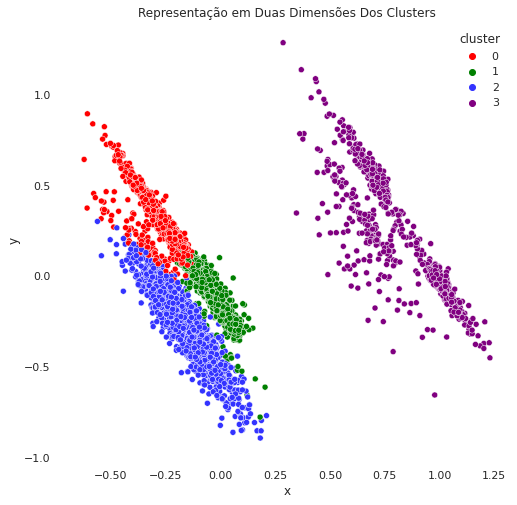

In [ ]:
#visualizando os clusters formados em um plano 2d
colors = {0:"red",1:"green",2:"#3333ff",3:"purple", 4:"yellow"}

fig, ax = plt.subplots(figsize=(8,8))
pca = PCA(n_components = 2)
components_df = pd.DataFrame(pca.fit_transform(data_cluster_scaled), columns = ["x","y"])
components_df["cluster"] = clusters

sns.scatterplot(data = components_df, x = "x", y = "y", hue="cluster", palette = colors, ax = ax )
ax.set(title= "Representação em Duas Dimensões Dos Clusters")
plt.show()

O cluster 3 parece ser o maiis distinto dentre todos

In [ ]:
#criando coluna com clusters no df final
data["cluster"] = clusters
data.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute,plan,churn,prob,cluster
0,KS,128,area_code_415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,75.56,717.2,304,0.105354,Apenas Correio de Voz,0,0.021287,2
1,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,59.24,625.2,333,0.094754,Apenas Correio de Voz,0,0.021355,2
2,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,62.29,539.4,333,0.115480,Nenhum,0,0.021331,1
3,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,66.80,564.8,257,0.118272,Apenas Internacional,0,0.021285,1
4,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,52.09,512.0,362,0.101738,Apenas Internacional,0,0.021337,0


In [ ]:
#agrupando por cluster
data.groupby("cluster").mean()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute,churn,prob
cluster,,,,,,,,,,,,,,,,,,,,,,,
0,101.317647,0.058039,0.074510,1.487843,126.049647,100.183529,21.429067,185.216314,100.629020,15.743702,194.526353,99.359216,8.753851,10.185333,4.497255,2.750533,1.280000,48.677153,515.977647,305.949020,0.094648,0.0,0.022126
1,99.789912,0.065523,0.016121,0.216329,202.610556,99.669787,34.444389,204.357930,100.252210,17.370614,201.172699,100.320333,9.052845,10.177327,4.487259,2.748367,1.565263,63.616214,618.318513,306.294852,0.103312,0.0,0.022433
2,98.509589,0.067580,1.000000,30.396347,186.435251,99.972603,31.694484,204.875708,99.771689,17.414621,202.177717,100.088584,9.098119,10.221096,4.454795,2.760301,1.475799,60.967525,603.709772,305.763470,0.101081,0.0,0.022067
3,102.332390,0.281471,0.144272,4.496464,207.870580,100.817539,35.338416,211.757850,99.884017,17.999562,206.078218,99.575672,9.273607,10.692362,4.151344,2.887426,2.254597,65.499010,636.399010,306.683168,0.102457,1.0,0.951643


Como os dados estão em diferentes escalas fica difícil gerar visualizações comparando as features entre cada cluster. Novamente, irei transformar os dados para um range de 0 a 1. 

In [ ]:
data_scal = data.select_dtypes(include = np.number)
col_names = data_scal.columns
data_scal = MinMaxScaler().fit_transform(data_scal)
data_scal = pd.DataFrame(data_scal, columns = col_names)
data_scal.drop("cluster", axis = 1)
data_scal["cluster"] = data.cluster

In [ ]:
data_scal.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute,churn,prob,cluster
0,0.524793,0.0,1.0,0.480769,0.754196,0.666667,0.754183,0.542755,0.582353,0.542866,0.619494,0.520000,0.619584,0.500,0.15,0.500000,0.111111,0.718793,0.720659,0.495575,0.611125,0.0,0.000006,2
1,0.438017,0.0,1.0,0.500000,0.459744,0.745455,0.459672,0.537531,0.605882,0.537690,0.644051,0.588571,0.644344,0.685,0.15,0.685185,0.111111,0.495903,0.567505,0.623894,0.442438,0.0,0.000077,2
2,0.561983,0.0,0.0,0.000000,0.692461,0.690909,0.692436,0.333242,0.647059,0.333225,0.411646,0.594286,0.411930,0.610,0.25,0.609259,0.000000,0.537558,0.424671,0.623894,0.772262,0.0,0.000052,1
3,0.342975,1.0,0.0,0.000000,0.851778,0.430303,0.851740,0.170195,0.517647,0.170171,0.498481,0.508571,0.498593,0.330,0.35,0.329630,0.222222,0.599153,0.466955,0.287611,0.816688,0.0,0.000004,1
4,0.305785,1.0,0.0,0.000000,0.474253,0.684848,0.474230,0.407754,0.717647,0.407959,0.473165,0.691429,0.473270,0.505,0.15,0.505556,0.333333,0.398252,0.379058,0.752212,0.553585,0.0,0.000059,0


In [ ]:
data_cluster_plot = data_scal.groupby("cluster").mean()
data_cluster_plot.reset_index(inplace=True)
data_cluster_plot

,cluster,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute,churn,prob
0,0,0.414536,0.058039,0.074510,0.028612,0.358605,0.607173,0.358585,0.509256,0.591935,0.509340,0.492472,0.567767,0.492620,0.509267,0.224863,0.509358,0.142222,0.351641,0.385679,0.504199,0.440752,0.0,0.000891
1,1,0.408223,0.065523,0.016121,0.004160,0.576417,0.604059,0.576379,0.561886,0.589719,0.561974,0.509298,0.573259,0.509445,0.508866,0.224363,0.508957,0.173918,0.555671,0.556049,0.505729,0.578633,0.0,0.001214
2,2,0.402932,0.067580,1.000000,0.584545,0.530399,0.605895,0.530363,0.563310,0.586892,0.563398,0.511842,0.571935,0.511993,0.511055,0.222740,0.511167,0.163978,0.519496,0.531729,0.503378,0.543130,0.0,0.000829
3,3,0.418729,0.281471,0.144272,0.086470,0.591381,0.611015,0.591339,0.582232,0.587553,0.582322,0.521717,0.569004,0.521869,0.534618,0.207567,0.534708,0.250511,0.581385,0.586148,0.507448,0.565025,1.0,0.981215


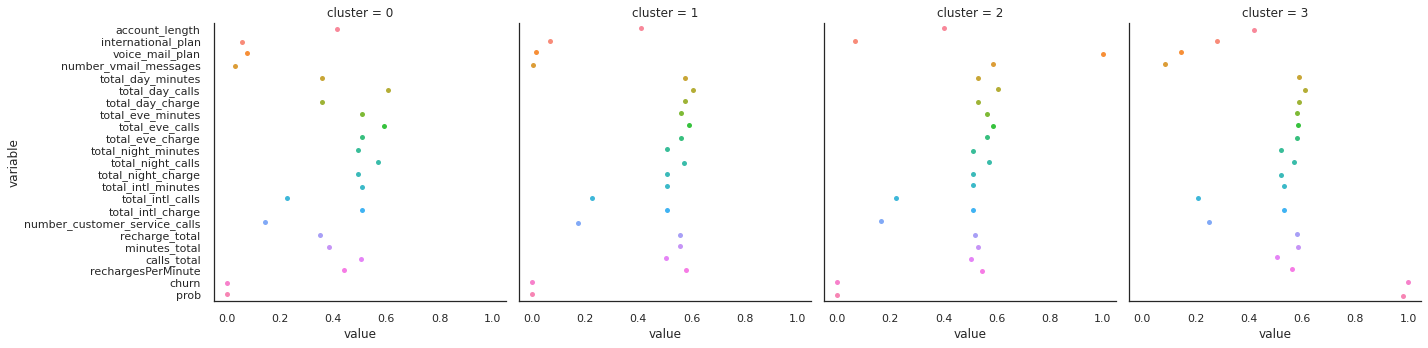

In [ ]:
sns.catplot(kind = "strip", data = data_cluster_plot.melt("cluster"), y = "variable", x = "value", col = "cluster", orient = "h");

Como são mutas featuresfica dificil avaliar as diferenças entre eles. Irei realizar plots com menos features.

In [ ]:
plot1 = lgbm_boruta_cols + ["prob","cluster"]
plot2 = ["cluster","total_day_minutes","total_eve_minutes", "total_night_minutes", "total_day_calls", "total_eve_calls", "total_night_calls", "total_day_charge", "total_eve_charge", "total_night_charge" ]

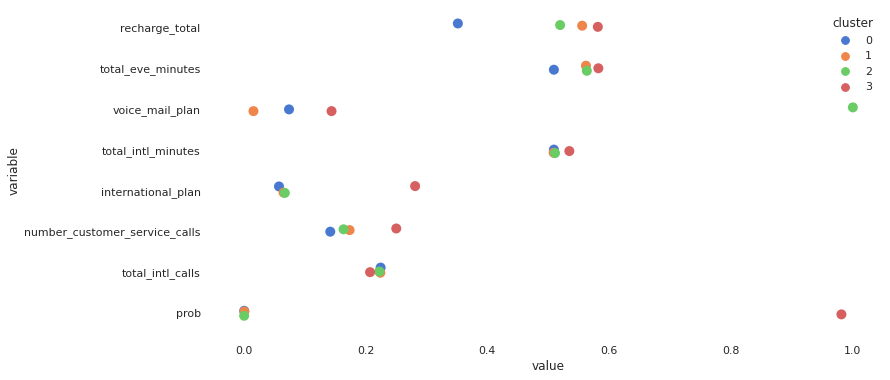

In [ ]:
fig,ax= plt.subplots(figsize = (12,6))
sns.stripplot(data= data_cluster_plot[plot1].melt("cluster"), size = 10, y = "variable", x = "value", hue = "cluster", orient = "h",
              ax = ax);

O cluster 3 foi o único com altas probabilidades de churn, também se diferiu dos demais pela superioridade em todas as features exceto adesão ao plano de correio de voz e total de chamadas internacionais. Essa diferença foi mais acentuada na adesão do plano internacional e número de chamadas ao serviço de atendimento.

Os clusters 0, 1 e 2 foram formados por clientes com baixa probabilidade de churn. No cluster 2 há um adesão ao plano de correio de voz bastante superior aos demais, ao passo que o cluster 1 foi o com menor adesão a esse plano. O cluster 0 apresentou uma baixa arrecadação em relação aos demais. 

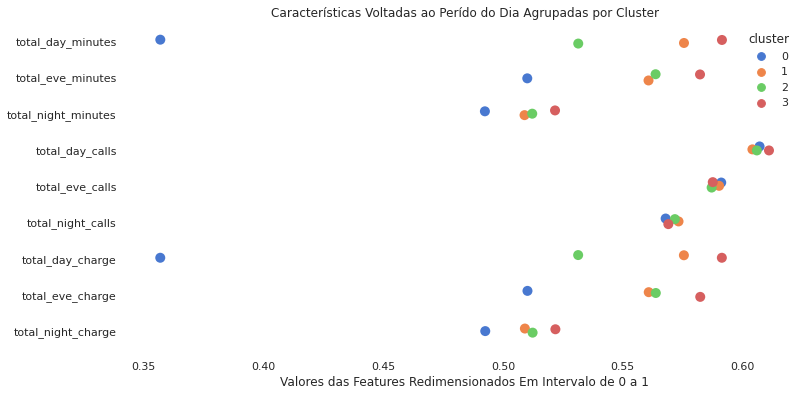

In [ ]:
fig,ax= plt.subplots(figsize = (12,6))
sns.stripplot(data= data_cluster_plot[plot2].melt("cluster"), size = 10, y = "variable", x = "value", hue = "cluster", orient = "h",
              ax = ax);
ax.set(title = "Características Voltadas ao Perído do Dia Agrupadas por Cluster",
       ylabel = "",
       xlabel = "Valores das Features Redimensionados Em Intervalo de 0 a 1");

As princiais características dos clusters foram:
- Cluster 0: Clientes com baixa probabilidade de churn e que fazem pouco uso dos serviços sendo os menos rentáveis.
- Cluster 1: Clientes com baixa probabilidade de churn, baixa adesão ao plano correio de voz e uso intermediário dos serviços de telecomunicação
- Cluster 2: Clientes com baixa probabilidade de chrun, uso intermediário, superior ao grupo 2 mas inferior ao 0, e que se diferem dos demais pela elevada adesão ao plano correio de voz.
- Cluster 3: Clientes com alta probabilidade de churn, elevada adesão ao plano internacional em relação aos outros grupos e são os que mais fazem uso dos serviços, sedo também os mais rentáveis.



# Exportando Arquivos Finais

In [ ]:
data.to_csv("../data/final_df.csv", index = False)
pickle.dump(k, open("../trained_models/kmeans.sav", 'wb'))
pickle.dump(final_lgbm_model, open("../trained_models/lgbm.sav", 'wb'))
pickle.dump(final_dt_model, open("../trained_models/dt.sav", 'wb'))

In [ ]:
k = pickle.load(open('../trained_models/kmeans.sav', 'rb'))
final_lgbm_model = pickle.load(open("../trained_models/lgbm.sav", 'rb'))
final_dt_model = pickle.load(open("../trained_models/dt.sav", 'rb'))
data = pd.read_csv("../data/final_df.csv")